### Installing and loading all required libraries

In [132]:
! pip install verstack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [133]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [134]:
!pip install seglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seglearn 
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import _prepare_data_corr_plot, _plot_corr
import statsmodels.graphics.utils as utils
from statsmodels.tsa.stattools import pacf

### Loading the daily data

In [137]:
# Connecting to the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [322]:
#loading daily data
daily_data = pd.read_csv('/content/drive/MyDrive/MADS_23_DL_final_project/data/crypto_data_daily_cleaned_v1.csv')

In [323]:
# columns in our data
daily_data.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto'],
      dtype='object')

In [325]:
#first 5 rows of our data
daily_data.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto
0,2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC
1,2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC
2,2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC
3,2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC
4,2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC


In [141]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20746 entries, 0 to 20745
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open Time   20746 non-null  object 
 1   Open        20746 non-null  float64
 2   High        20746 non-null  float64
 3   Low         20746 non-null  float64
 4   Close       20746 non-null  float64
 5   Volume      20746 non-null  float64
 6   train_test  20746 non-null  object 
 7   Crypto      20746 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


### EDA

In [326]:
#setting Open Time as index
daily_data=daily_data.set_index('Open Time')

In [347]:
# train test split to make sure that there's no contamination
train_df = daily_data[daily_data['train_test']=='Train']
test_df = daily_data[daily_data['train_test']=='Test']

In [330]:
#function to create daily returns column 
def calculate_pct_change(df):
  coins = df.Crypto.unique()
  df_pct_change = pd.DataFrame()
  for coin in coins:
    x = df[df['Crypto']==coin]
    x['pct_change_1day'] = x['Close'].pct_change(1)
    df_pct_change = pd.concat([df_pct_change,x])
  return df_pct_change

In [348]:
#Adding daily returns to test and train data
train_df= calculate_pct_change(train_df)
test_df= calculate_pct_change(test_df)

In [332]:
train_df.head()

,Open,High,Low,Close,Volume,train_test,Crypto,pct_change_1day
Open Time,,,,,,,,
2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC,NaN
2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC,0.174377
2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC,0.020192
2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC,0.080733
2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC,0.054250


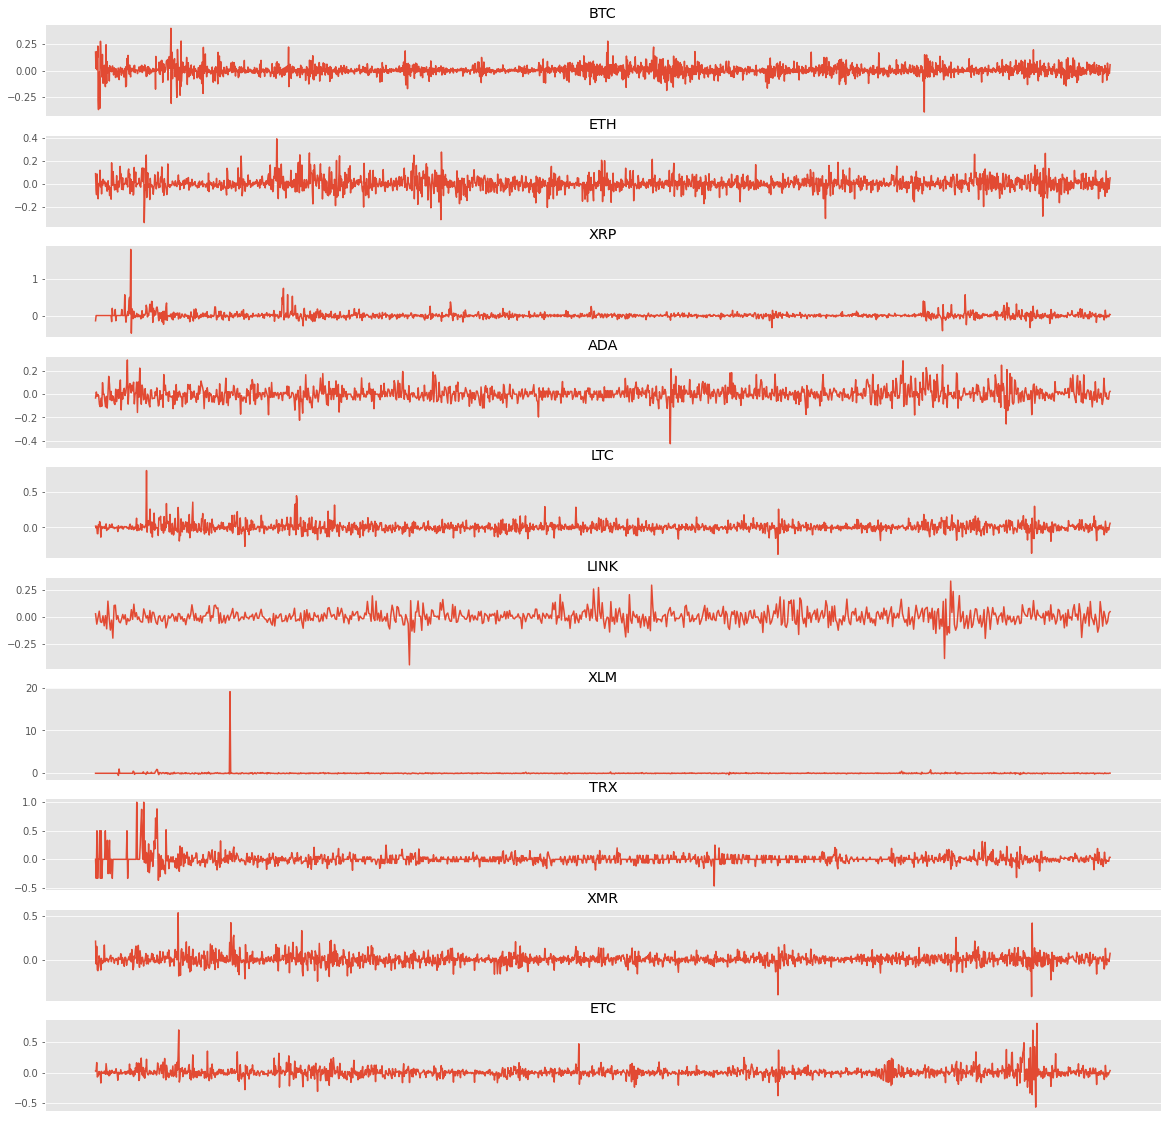

In [333]:
#Plotting 1 day returns for all coins

coins = train_df['Crypto'].unique()

f,ax = plt.subplots(len(coins),figsize=(20,20))
for i in range(len(coins)):
  
  ax[i].plot(train_df.index[train_df['Crypto']==coins[i]],train_df.pct_change_1day[train_df['Crypto']==coins[i]])
  ax[i].title.set_text(coins[i])
  ax[i].set_xticks([])
  

Daily return is generally considered stationary. Here, the mean Return for all coins seems to be constant, but we can't say the same for volatility. But we are going ahead with the stationary assumption anyways and plotting pacf for all coins to find out relevant lags that we can use to model our dep variable; 1 day Return

In [334]:
# pacf plot function

def plot_pacf_drop(x, ax=None, lags=None, alpha=.05, method='ywunbiased',
              use_vlines=True, title='Partial Autocorrelation', zero=True,
              vlines_kwargs=None, drop_no=0, **kwargs):
    
    lags_orig=lags
    fig, ax = utils.create_mpl_ax(ax)
    vlines_kwargs = {} if vlines_kwargs is None else vlines_kwargs
    lags, nlags, irregular = _prepare_data_corr_plot(x, lags, zero)
    confint = None
    if alpha is None:
        acf_x = pacf(x, nlags=nlags, alpha=alpha, method=method)
    else:
        acf_x, confint = pacf(x, nlags=nlags, alpha=alpha, method=method)

    if drop_no:
        acf_x = acf_x[drop_no+1:]
        confint = confint[drop_no+1:]
        lags, nlags, irregular = _prepare_data_corr_plot(x, lags_orig-drop_no, zero)
        
    _plot_corr(ax, title, acf_x, confint, lags, False, use_vlines,
               vlines_kwargs, **kwargs)

    return fig

We will be collecting all the relevant lags (lags with abs(pacf) >0.06) for all the individual coins in a list and will be using all of these lags in our model

Significant lags for BTC is [10, 17]
Significant lags for ETH is [10]
Significant lags for XRP is [2, 3, 16, 35, 36, 60]
Significant lags for ADA is [1, 2, 4, 35, 36, 59]
Significant lags for LTC is [6]
Significant lags for LINK is [1, 4, 12, 13, 20, 29, 39, 48, 49]
Significant lags for XLM is []
Significant lags for TRX is [2, 3, 9, 11, 15, 17, 20, 22, 38, 45, 52]
Significant lags for XMR is [1, 6, 23]
Significant lags for ETC is [1, 4, 6, 9, 14, 20, 39, 54, 59]
Significant lags we'll be taking for daily returns {1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 29, 35, 36, 38, 39, 45, 48, 49, 52, 54, 59, 60}


<Figure size 432x288 with 0 Axes>

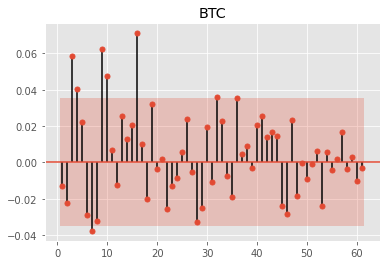

<Figure size 432x288 with 0 Axes>

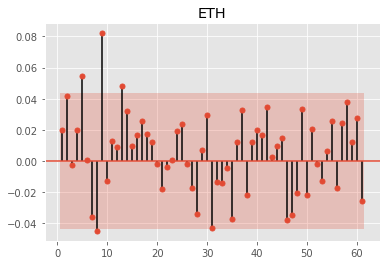

<Figure size 432x288 with 0 Axes>

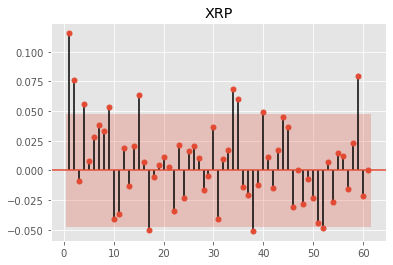

<Figure size 432x288 with 0 Axes>

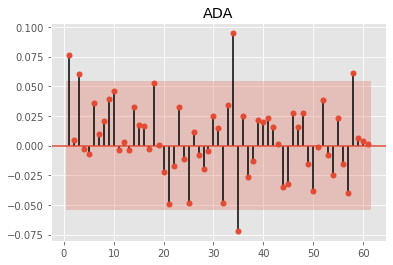

<Figure size 432x288 with 0 Axes>

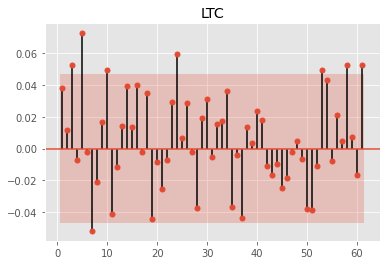

<Figure size 432x288 with 0 Axes>

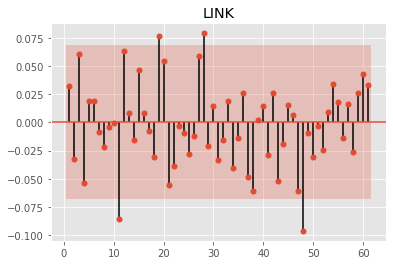

<Figure size 432x288 with 0 Axes>

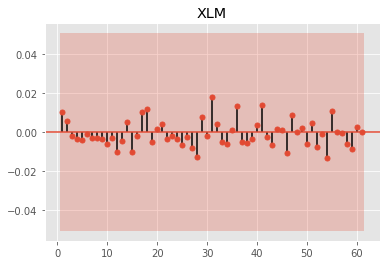

<Figure size 432x288 with 0 Axes>

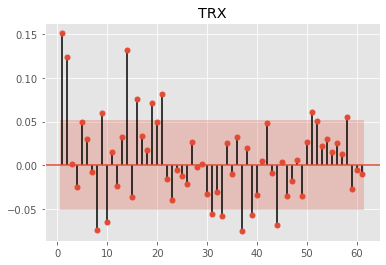

<Figure size 432x288 with 0 Axes>

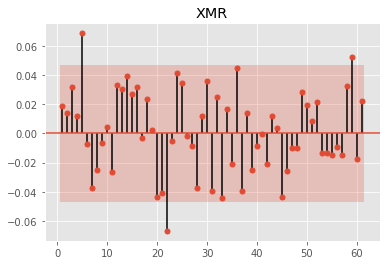

<Figure size 432x288 with 0 Axes>

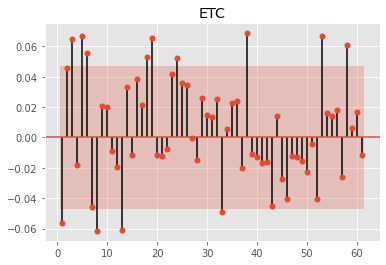

In [335]:
#list to collect all relevant lags 
master_list=[]

coins = train_df['Crypto'].unique()
for coin in coins:
  #pacf plot for all coins
  plt.figure()
  plot_pacf_drop(train_df['pct_change_1day'][train_df['Crypto']==coin].dropna(),lags=62,drop_no=1,zero=False,title=coin)
  k=pacf(train_df.pct_change_1day[train_df['Crypto']==coin].dropna(), nlags=62, alpha=0.05)
  ar_name=str(coin)+"array"
  ar_name=[]
  for i in range(1,len(k[0])):
    if k[0][i]>=0.06 or k[0][i]<=-0.06:
      ar_name.append(i)
      master_list.append(i)
  
  print(f"Significant lags for {coin} is {ar_name}")

print(f"Significant lags we'll be taking for daily returns {set(master_list)}")
plt.show()  

#master list with all unique relevant lags
lag_list=list(set(master_list))

### Feature Engineering

####1.Adding lagged Technical Indicators as features

Technical indicators use price and volume information to identify statistical trends from historical trading activity to predict future movements in price or volume.We will model technical indicators for all the crypto coins seperately from daily data. For that we will be using the Technical Analysis library in python.

We will be using four classes of Technical Indicators namely, Momentum, Volume, Volatility and Trend. We will be modelling all the TI's for the four classes mentioned above. Further information about individual TI's could be found here:  [TI summary](https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html)



1. Momentum Indicators (18 TI's):
       'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama'
2. Volume Indicators (13 TI's):
       'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap',
       'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl'
3. Volatility Indicators (21 TI's):
       'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui'
4.Trend Indicators (34 TI's):
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator'      



In [349]:
#Function to add all TI indicators and shifting them by 1 time step
def add_TI_indicators(df):
  master_df_list=[]
  from ta import add_all_ta_features
  coins = df['Crypto'].unique()
  for coin in coins:
    df_name = add_all_ta_features(df[df['Crypto']==coin], open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    for ti in df_name.columns[8:]:
      df_name[ti] = df_name[ti].shift(1)
    master_df_list.append(df_name)

  #final data with all the new TI features shifted by 1 time step
  return pd.concat(master_df_list)
  



In [350]:
#Adding all TI indicators and shifting them by 1 time step
train_df=add_TI_indicators(train_df)
test_df=add_TI_indicators(test_df)

In [351]:
train_df.head()

,Open,High,Low,Close,Volume,train_test,Crypto,pct_change_1day,volume_adi,volume_obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Open Time,,,,,,,,,,,,,,,,,,,,,
2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC,0.174377,9021.893541,11008.524,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,104.750000,-98.630039,0.000000,0.000000
2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC,0.020192,26326.249139,35195.922,...,1.373304,0.274661,1.098643,8.772042,1.754408,7.017634,112.777467,17.437709,16.073787,17.437709
2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC,0.080733,28148.148762,66877.702,...,2.585350,0.736798,1.848551,18.304684,5.064463,13.240220,118.675411,2.019250,1.999133,19.809069
2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC,0.054250,30522.852156,81912.908,...,4.190370,1.427513,2.762857,16.290052,7.309581,8.980471,125.892213,8.073307,7.763958,29.481623


####2.Adding lagged pct_change_1day as features for every relevant lag in the lag list

In [339]:
#function to create lagged pct_change col for every relevant lag
def create_shift_features(df,col,lag_list):
  master_df_list=[]
  crypto_coins = df['Crypto'].unique()
  for coin in crypto_coins:
    temp_df = df[df['Crypto']==coin]
    for lag in lag_list:
    
      temp_df['{}d_lag_{}'.format(lag,col)] = temp_df[col].shift(periods=lag)
    master_df_list.append(temp_df)
  return pd.concat(master_df_list)

In [352]:
#adding all lags to trai and test data
train_df = create_shift_features(train_df,'pct_change_1day',lag_list)
test_df = create_shift_features(test_df,'pct_change_1day',lag_list)
#Adding lagged Close value to plot the predictions for Close at the end
test_df=create_shift_features(test_df,'Close',[1])

In [341]:
test_df.head()

,Open,High,Low,Close,Volume,train_test,Crypto,pct_change_1day,volume_adi,volume_obv,...,38d_lag_pct_change_1day,39d_lag_pct_change_1day,45d_lag_pct_change_1day,48d_lag_pct_change_1day,49d_lag_pct_change_1day,52d_lag_pct_change_1day,54d_lag_pct_change_1day,59d_lag_pct_change_1day,60d_lag_pct_change_1day,1d_lag_Close
Open Time,,,,,,,,,,,,,,,,,,,,,
2021-10-01,43828.89,48500.00,43287.44,48165.76,38375.517,Test,BTC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-02,48185.61,48361.83,47438.00,47657.69,12310.011,Test,BTC,-0.010548,33454.083845,38375.517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48165.76
2021-10-03,47649.00,49300.00,47119.87,48233.99,14411.104,Test,BTC,0.012092,26998.800050,26065.506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47657.69
2021-10-04,48233.99,49530.53,46895.80,49245.54,25695.213,Test,BTC,0.020972,27316.816963,40476.610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48233.99
2021-10-05,49244.13,51922.00,49057.18,51493.99,30764.491,Test,BTC,0.045658,47453.298136,66171.823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49245.54


####3.Adding Time based features as ordinals

In [342]:
def encode_cyclicals(df_x):
    #"year","month","day","dayofweek"


    df_x['year'] = pd.DatetimeIndex(df_x.index).year
    df_x['month'] = pd.DatetimeIndex(df_x.index).month
    df_x['day'] = pd.DatetimeIndex(df_x.index).day
    df_x['weekday'] = pd.DatetimeIndex(df_x.index).dayofweek

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)
    
    df_x['day_sin'] = np.sin(2*np.pi*df_x.day/31)
    df_x['day_cos'] = np.cos(2*np.pi*df_x.day/31)
    df_x.drop('day', axis=1, inplace=True)

    df_x['dayofweek_sin'] = np.sin(2*np.pi*df_x.weekday/7)
    df_x['dayofweek_cos'] = np.cos(2*np.pi*df_x.weekday/7)
    df_x.drop('weekday', axis=1, inplace=True)
    
    
    return df_x

In [353]:
#adding time based features
train_df = encode_cyclicals(train_df)
test_df = encode_cyclicals(test_df)

####4.One hot Encoding the coins

In [354]:
# One hot encoding the train data and dropping all the NA
y_dummies = pd.get_dummies(train_df['Crypto'], prefix='Crypto', drop_first= False)
train_df = pd.concat([train_df, y_dummies], axis=1)
train_df=train_df.dropna()

In [355]:
# One hot encoding the test data
y_dummies = pd.get_dummies(test_df['Crypto'], prefix='Crypto', drop_first= False)
test_df = pd.concat([test_df, y_dummies], axis=1)
test_df=test_df.dropna()

In [356]:
train_df.head()

,Open,High,Low,Close,Volume,train_test,Crypto,pct_change_1day,volume_adi,volume_obv,...,Crypto_ADA,Crypto_BTC,Crypto_ETC,Crypto_ETH,Crypto_LINK,Crypto_LTC,Crypto_TRX,Crypto_XLM,Crypto_XMR,Crypto_XRP
Open Time,,,,,,,,,,,,,,,,,,,,,
2013-06-01,127.370,129.00,127.00,128.79,2656.044,Train,BTC,0.005308,279396.436562,-46028.787,...,0,1,0,0,0,0,0,0,0,0
2013-06-02,128.190,132.65,117.00,120.46,30651.941,Train,BTC,-0.064679,281494.711322,-43372.743,...,0,1,0,0,0,0,0,0,0,0
2013-06-03,120.231,132.87,117.00,122.61,10174.907,Train,BTC,0.017848,264396.216438,-74024.684,...,0,1,0,0,0,0,0,0,0,0
2013-06-04,123.360,123.50,116.42,120.39,12153.878,Train,BTC,-0.018106,261414.910984,-63849.777,...,0,1,0,0,0,0,0,0,0,0
2013-06-05,121.070,122.37,119.60,120.30,3684.616,Train,BTC,-0.000748,262891.229499,-76003.655,...,0,1,0,0,0,0,0,0,0,0


In [357]:
len(train_df)

16515

In [358]:
len(test_df)

3011

We have 16515 rows to train our model and 3011 for testing

### Modelling our Target variable

In [359]:
# train test split for target col
train_target = train_df.pct_change_1day

test_target=test_df.pct_change_1day

#For plotting the results at the end not for training
train_crypto_col=train_df.Crypto
test_crypto_col=test_df.Crypto
test_Close=test_df.Close
test_Close_1dlag=test_df["1d_lag_Close"]

#dropping all the redundant columns
train_df.drop(['others_dr', 'others_dlr', 'others_cr','train_test','pct_change_1day','Open', 'High', 'Low', 'Close', 'Volume','Crypto'], axis=1, inplace=True)
test_df.drop(['others_dr', 'others_dlr', 'others_cr','train_test','pct_change_1day','Open', 'High', 'Low', 'Close', 'Volume','Crypto','1d_lag_Close'], axis=1, inplace=True)

In [360]:
len(train_df)

16515

In [361]:
len(test_df)

3011

In [234]:
len(train_df.columns)

129

In [235]:
len(test_df.columns)

129

We will be using 129 columns for training our Regressor

### Baseline model

In [362]:
from sklearn.dummy import DummyRegressor

#loading the mean dummy regressor as the baseline model
dummy_model = DummyRegressor(strategy="mean")

#fitting the dumb model
dummy_model.fit(train_df,train_target)

DummyRegressor()

In [363]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#predicting t+1 
test_pred_dummy = dummy_model.predict(test_df)

#calculating RMSE
rms = sqrt(mean_squared_error(test_target, test_pred_dummy))
print("Root mean squared error on test:",rms)

Root mean squared error on test: 0.04872778321537305


In [364]:
#creating the dataframe for plotting the predictions v/s true values
test_plot_df_dummy=test_target.to_frame()
test_plot_df_dummy["test_pred"]=test_pred_dummy
test_plot_df_dummy["Crypto"]=test_crypto_col

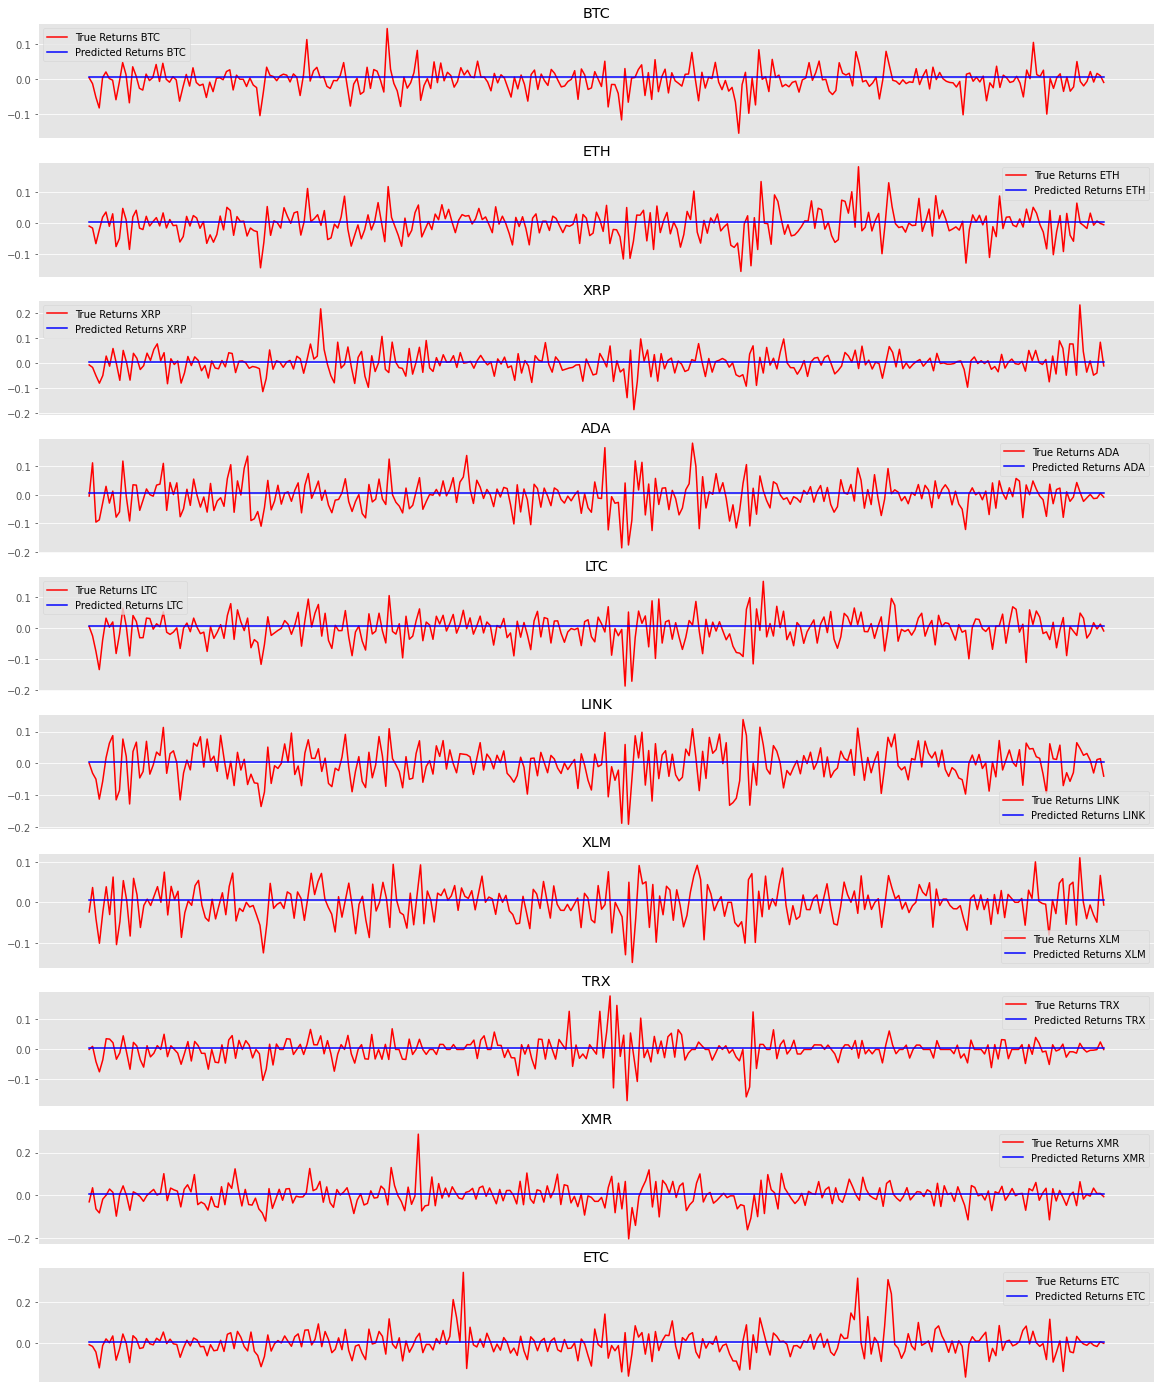

In [365]:
#plotting the predictions vs true values for all coins
coins = test_plot_df_dummy['Crypto'].unique()
f,ax = plt.subplots(len(coins),figsize=(20, 25))

for i in range(len(coins)):
  label_1="True Returns "+str(coins[i])
  label_2="Predicted Returns "+str(coins[i])
  ax[i].plot(test_plot_df_dummy.index[test_plot_df_dummy['Crypto']==coins[i]],test_plot_df_dummy.pct_change_1day[test_plot_df_dummy['Crypto']==coins[i]],color = 'red', label = label_1)
  ax[i].plot(test_plot_df_dummy.index[test_plot_df_dummy['Crypto']==coins[i]],test_plot_df_dummy.test_pred[test_plot_df_dummy['Crypto']==coins[i]],color = 'blue', label = label_2)
  ax[i].title.set_text(coins[i])
  ax[i].set_xticks([])
  ax[i].legend()

### LGBM Regression

####LGBM Feature Set Selection Using Random Selection Method

In [366]:
#function to select feature set based on random numbers
def select_feature_space(df,selector):  
  #selector=[volume ta, volatility ta, trent ta, momentum ta,7 day lag,31 day PCA lags,62 day PCA lags, ordinals]
  
  master_df_list=[]
  for i in range(len(selector)):
    if i==0 and selector[i]==1:
      master_df_list.append(df[df.columns[:10]])
    elif i==1 and selector[i]==1:
      master_df_list.append(df[df.columns[10:31]])
    elif i==2 and selector[i]==1:
      master_df_list.append(df[df.columns[31:65]])
    elif i==3 and selector[i]==1:
      master_df_list.append(df[df.columns[65:83]])
    elif i==4 and selector[i]==1:
      master_df_list.append(df[df.columns[83:88]])
    elif i==5 and selector[i]==1:
      master_df_list.append(df[df.columns[88:101]])
    elif i==6 and selector[i]==1:
      master_df_list.append(df[df.columns[101:112]])
    elif i==7 and selector[i]==1:
      master_df_list.append(df[df.columns[112:119]])


  master_df_list.append(df[df.columns[119:]])
  return pd.concat(master_df_list,axis=1)

In [367]:
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
import lightgbm as lgb

#Choose number of iterations 
iterations=100

master_list=[]
#creating empty df to collect the results


# defining parameters for lgbm
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'max_depth':12,
    'num_leaves': 4096,
    'learning_rate': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1,
    'n_estimators':250
}

for i in range(iterations):
   
  #switch to randomly select the feature space
  selector=random.choices([1,0],k=8)
  #for the corner case
  if selector==[0,0,0,0,0,0,0,0]:
    continue

  print(f"The Random Selector List is {selector}")

  #selector=[volume ta, volatility ta, trent ta, momentum ta,7day PCA lags,7-31 day PCA lags,62 day PCA lags, ordinals]

  #creating train and test data 
  train_df_final=select_feature_space(train_df,selector)
  test_df_final=select_feature_space(test_df,selector)

  # loading data
  lgb_train = lgb.Dataset(train_df_final, train_target)
  lgb_eval = lgb.Dataset(test_df_final,test_target, reference=lgb_train)

  # fitting the model
  lgb_model_trial = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)
  # prediction
  test_pred_lgbm_trial = lgb_model_trial.predict(test_df_final)

  
  #calculating rmse
  rms_trial = sqrt(mean_squared_error(test_target, test_pred_lgbm_trial))

  selector.append(rms_trial)
  master_list.append(selector)

#dataframe to store the results of our randomisation feature selection process  
df_rmse = pd.DataFrame(master_list,columns=["volume_ta", "volatility_ta", "trent_ta", "momentum_ta","7_day_PCAlags","8-31_day_PCAlags","62_day_PCAlags", "ordinals","rmse"])
  


The Random Selector List is [0, 1, 0, 1, 0, 0, 0, 1]
[1]	valid_0's l1: 0.0354629	valid_0's l2: 0.00237234
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l1: 0.0354636	valid_0's l2: 0.00237163
[3]	valid_0's l1: 0.0354827	valid_0's l2: 0.00237191
[4]	valid_0's l1: 0.0354723	valid_0's l2: 0.00237147
[5]	valid_0's l1: 0.0356723	valid_0's l2: 0.00238745
[6]	valid_0's l1: 0.0357318	valid_0's l2: 0.00239058
[7]	valid_0's l1: 0.0358552	valid_0's l2: 0.00240217
[8]	valid_0's l1: 0.0359394	valid_0's l2: 0.00240814
[9]	valid_0's l1: 0.036036	valid_0's l2: 0.00241664
[10]	valid_0's l1: 0.0360441	valid_0's l2: 0.00241728
[11]	valid_0's l1: 0.0360754	valid_0's l2: 0.00242145
[12]	valid_0's l1: 0.0360264	valid_0's l2: 0.00241667
[13]	valid_0's l1: 0.0360868	valid_0's l2: 0.00242183
[14]	valid_0's l1: 0.0361794	valid_0's l2: 0.00242901
[15]	valid_0's l1: 0.0362954	valid_0's l2: 0.00244062
[16]	valid_0's l1: 0.0363469	valid_0's l2: 0.00244502
[17]	valid_0's l1: 0.0364266	val

In [368]:
#results sorted from best to worst rmse
df_rmse.sort_values(by=['rmse'])

,volume_ta,volatility_ta,trent_ta,momentum_ta,7_day_PCAlags,8-31_day_PCAlags,62_day_PCAlags,ordinals,rmse
93,0,1,0,0,1,0,0,0,0.048215
45,0,1,0,1,1,0,0,0,0.048269
50,0,1,0,1,1,0,0,0,0.048269
91,1,0,1,1,0,1,0,0,0.048287
74,0,0,1,1,0,1,0,0,0.048302
...,...,...,...,...,...,...,...,...,...
41,0,1,0,0,0,1,1,1,0.048772
79,1,1,0,0,0,1,1,1,0.048786
20,1,1,1,0,0,1,1,0,0.048787
73,1,1,1,0,0,1,1,0,0.048787


In [369]:
#creating the final test and train data based on the best rmse score
selector_list=list(df_rmse.loc[df_rmse.sort_values(by=['rmse']).index[0]][:7])
train_df_final_v1=select_feature_space(train_df,selector_list)
test_df_final_v1=select_feature_space(test_df,selector_list)

In [370]:
len(train_df_final_v1.columns)

36

For our final train data, we only have 36 columns. Lagged Volatility Indicators and lagged pct values for a week seems to be the relevant features 

In [372]:
#The columns we use for training
train_df_final_v1.columns

Index(['volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui',
       '1d_lag_pct_change_1day', '2d_lag_pct_change_1day',
       '3d_lag_pct_change_1day', '4d_lag_pct_change_1day',
       '6d_lag_pct_change_1day', 'Crypto_ADA', 'Crypto_BTC', 'Crypto_ETC',
       'Crypto_ETH', 'Crypto_LINK', 'Crypto_LTC', 'Crypto_TRX', 'Crypto_XLM',
       'Crypto_XMR', 'Crypto_XRP'],
      dtype='object')

In [373]:
#Using our best performing features for our LGBM Model
import lightgbm as lgb

# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'max_depth':12,
    'num_leaves': 4096,
    'learning_rate': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1,
    'n_estimators':250
}

In [374]:
# loading data
lgb_train = lgb.Dataset(train_df_final_v1, train_target)
lgb_eval = lgb.Dataset(test_df_final_v1,test_target, reference=lgb_train)

In [375]:
# fitting the model
lgb_model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=100)

[1]	valid_0's l1: 0.0353931	valid_0's l2: 0.00236281
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.0353482	valid_0's l2: 0.00235556
[3]	valid_0's l1: 0.0352837	valid_0's l2: 0.00234778
[4]	valid_0's l1: 0.0352405	valid_0's l2: 0.00234204
[5]	valid_0's l1: 0.0352034	valid_0's l2: 0.00233797
[6]	valid_0's l1: 0.0351907	valid_0's l2: 0.00233585
[7]	valid_0's l1: 0.0351774	valid_0's l2: 0.0023332
[8]	valid_0's l1: 0.0351273	valid_0's l2: 0.00232807
[9]	valid_0's l1: 0.0351366	valid_0's l2: 0.00232826
[10]	valid_0's l1: 0.0351213	valid_0's l2: 0.00232471
[11]	valid_0's l1: 0.0351284	valid_0's l2: 0.00232515
[12]	valid_0's l1: 0.0351467	valid_0's l2: 0.00232845
[13]	valid_0's l1: 0.0351292	valid_0's l2: 0.00232708
[14]	valid_0's l1: 0.0351437	valid_0's l2: 0.00232703
[15]	valid_0's l1: 0.0351355	valid_0's l2: 0.00232712
[16]	valid_0's l1: 0.0351634	valid_0's l2: 0.00233149
[17]	valid_0's l1: 0.0351671	valid_0's l2: 0.00233311
[18]	valid_0's l1: 0.0351889	v

In [382]:
# prediction
test_pred_lgbm = lgb_model.predict(test_df_final_v1)

from sklearn.metrics import mean_squared_error
from math import sqrt
#calculating rmse
rms = sqrt(mean_squared_error(test_target, test_pred_lgbm))
print("Root mean squared error on test for LGBM model:",rms)

Root mean squared error on test for LGBM model: 0.048215272624038276


In [377]:
#creating the dataframe for plotting the predictions v/s true values
test_plot_df_lgbm=test_target.to_frame()
test_plot_df_lgbm["test_pred"]=test_pred_lgbm
test_plot_df_lgbm["test_pred"]=test_pred_lgbm
test_plot_df_lgbm["Crypto"]=test_crypto_col
test_plot_df_lgbm["Close_1dlag"]=test_Close_1dlag
#calculating the next day Close price using the predicted returns
test_plot_df_lgbm["Close_pred"]=test_plot_df_lgbm["Close_1dlag"]*test_plot_df_lgbm["test_pred"]+test_plot_df_lgbm["Close_1dlag"]
test_plot_df_lgbm["Close"]=test_Close

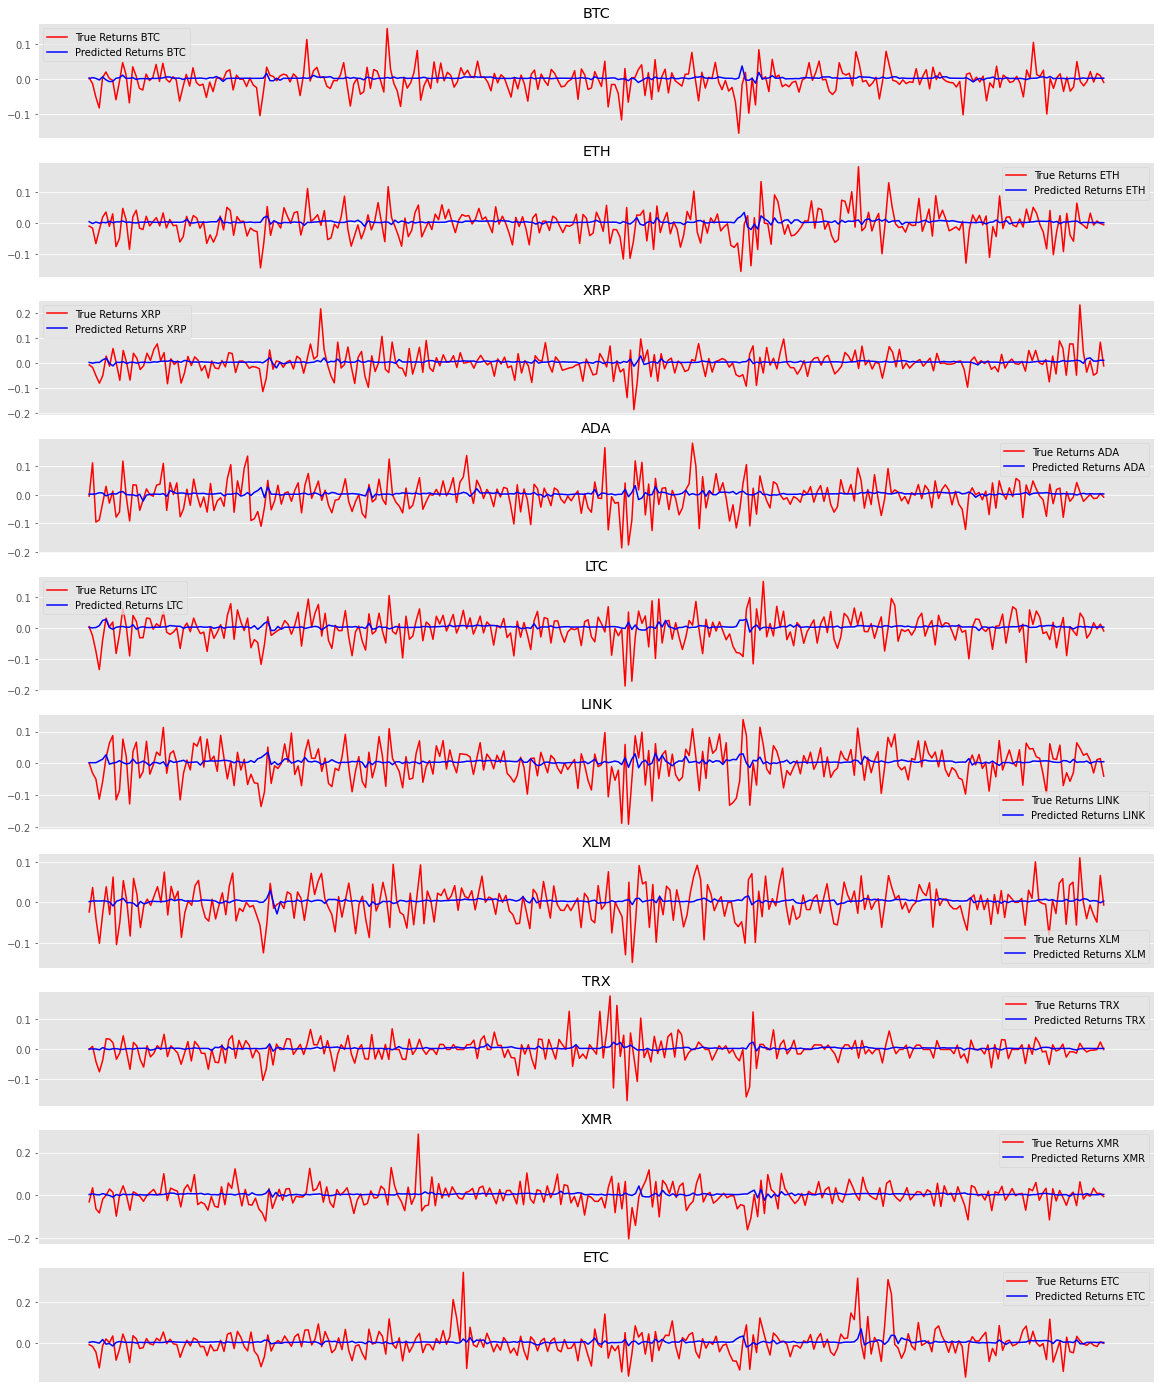

In [378]:
#plotting the predictions vs true values for all coins
coins = test_plot_df_lgbm['Crypto'].unique()
f,ax = plt.subplots(len(coins),figsize=(20, 25))

for i in range(len(coins)):
  label_1="True Returns "+str(coins[i])
  label_2="Predicted Returns "+str(coins[i])
  ax[i].plot(test_plot_df_lgbm.index[test_plot_df_lgbm['Crypto']==coins[i]],test_plot_df_lgbm.pct_change_1day[test_plot_df_lgbm['Crypto']==coins[i]],color = 'red', label = label_1)
  ax[i].plot(test_plot_df_lgbm.index[test_plot_df_lgbm['Crypto']==coins[i]],test_plot_df_lgbm.test_pred[test_plot_df_lgbm['Crypto']==coins[i]],color = 'blue', label = label_2)
  ax[i].title.set_text(coins[i])
  ax[i].set_xticks([])
  ax[i].legend()

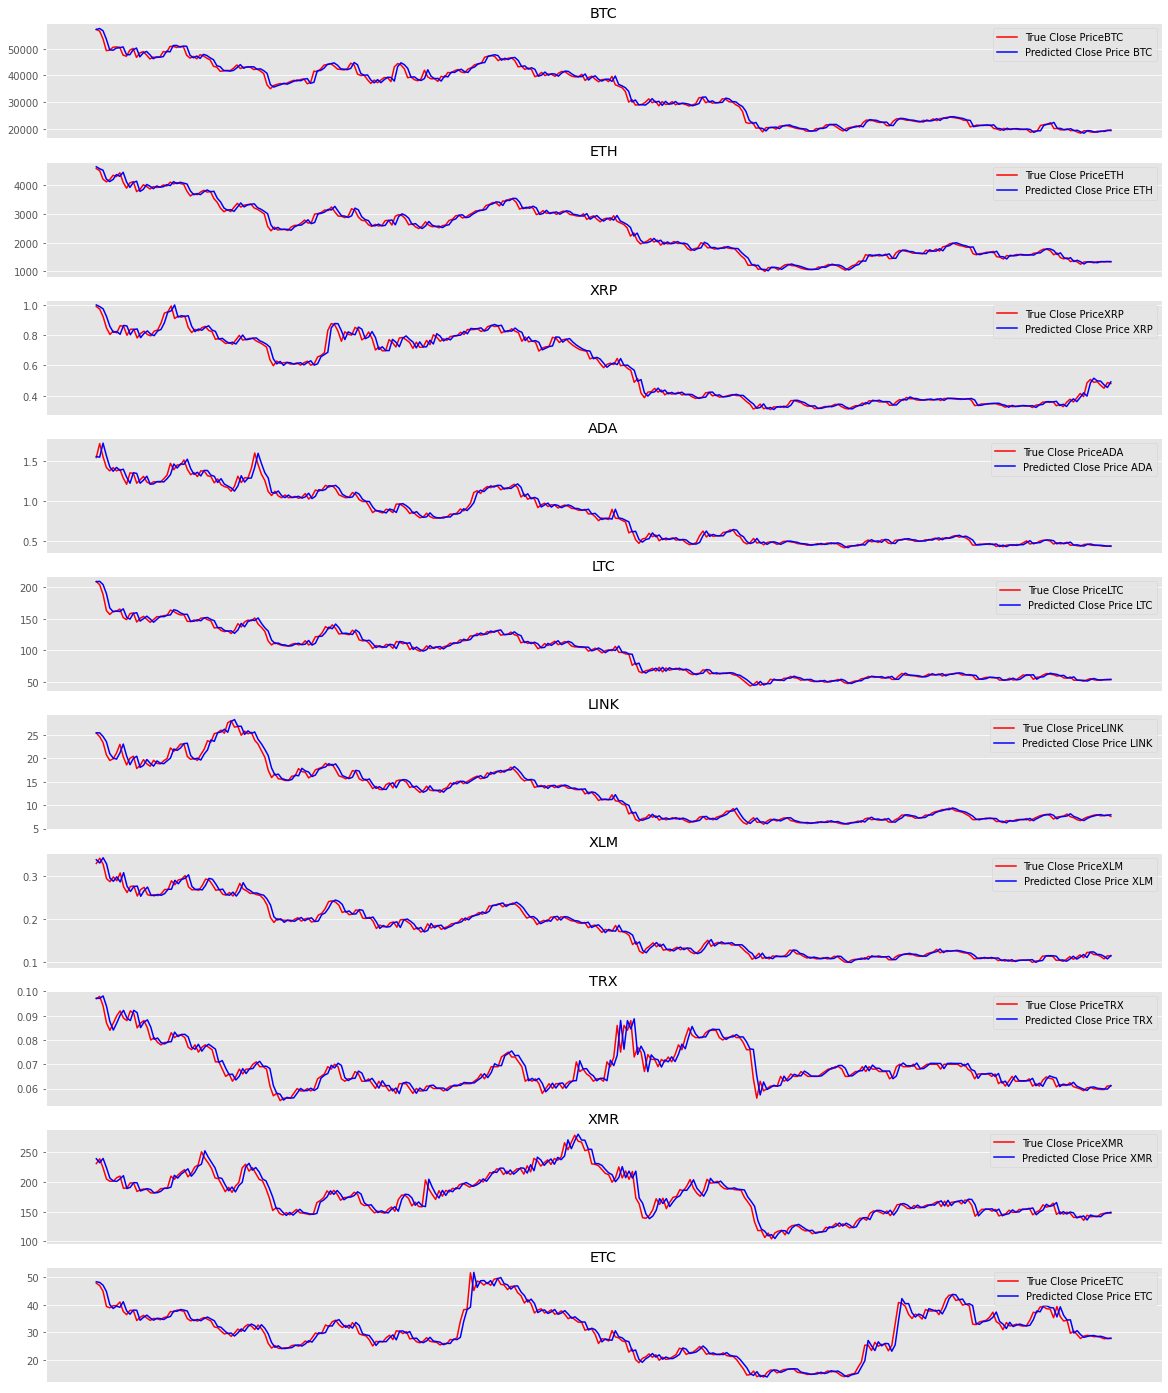

In [379]:
#Using the 1 day return predictions to calculate t+1 closing price and plotting vs true values of Close Prices for all coins
coins = test_plot_df_lgbm['Crypto'].unique()
f,ax = plt.subplots(len(coins),figsize=(20, 25))

for i in range(len(coins)):
  label_1="True Close Price"+str(coins[i])
  label_2="Predicted Close Price "+str(coins[i])
  ax[i].plot(test_plot_df_lgbm.index[test_plot_df_lgbm['Crypto']==coins[i]],test_plot_df_lgbm.Close[test_plot_df_lgbm['Crypto']==coins[i]],color = 'red', label = label_1)
  ax[i].plot(test_plot_df_lgbm.index[test_plot_df_lgbm['Crypto']==coins[i]],test_plot_df_lgbm.Close_pred[test_plot_df_lgbm['Crypto']==coins[i]],color = 'blue', label = label_2)
  ax[i].title.set_text(coins[i])
  ax[i].set_xticks([])
  ax[i].legend()

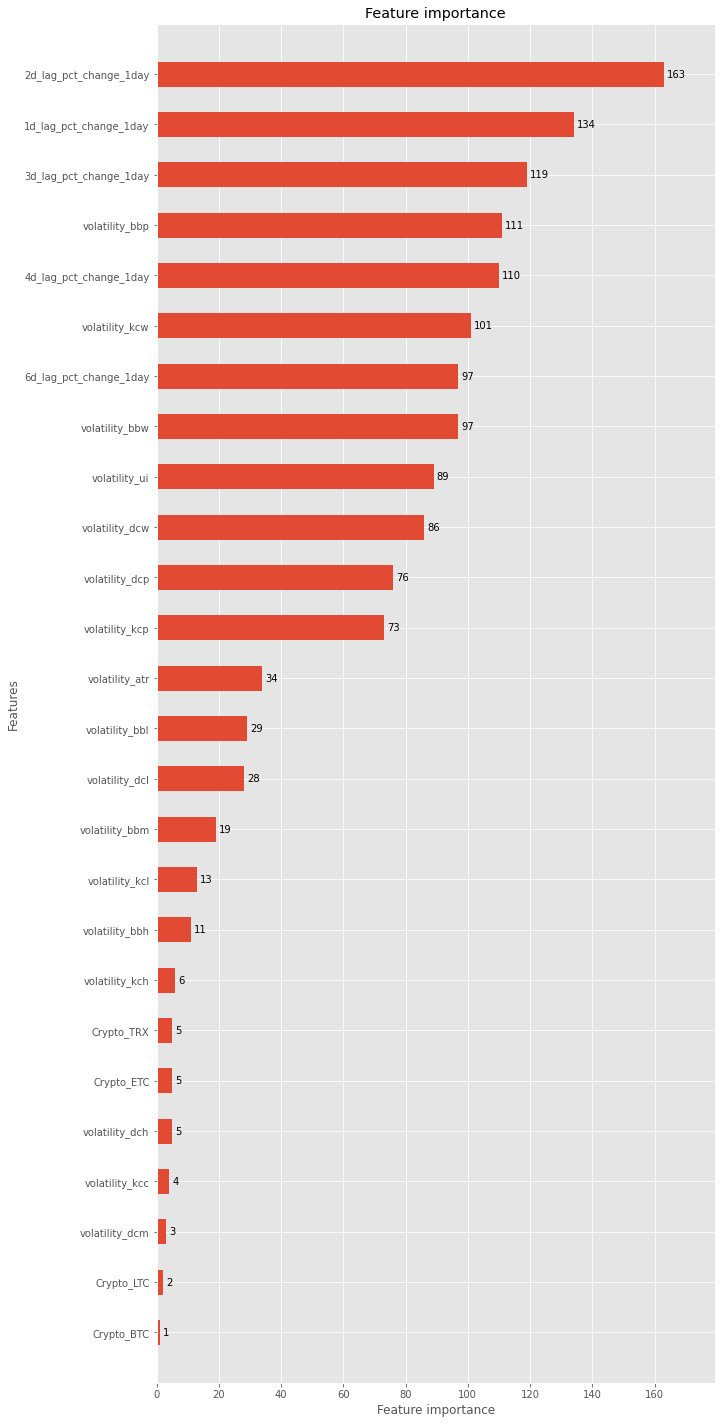

In [380]:
# plotting feature importance
lgb.plot_importance(lgb_model, height=.5,figsize=(10,25))
  


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.06765917156304006
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.06844006569107612
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.06709567069918762
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 0.06457561684747148
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 0.06896574331152938
 .........................................

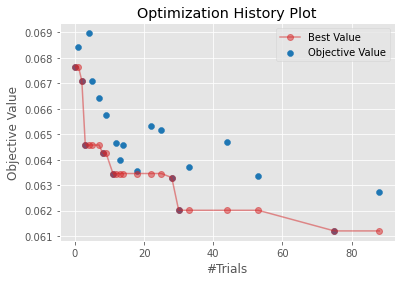

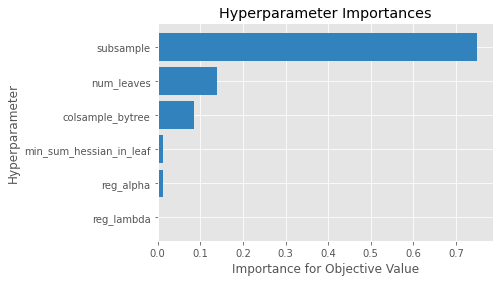

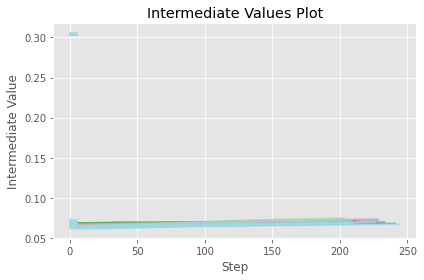

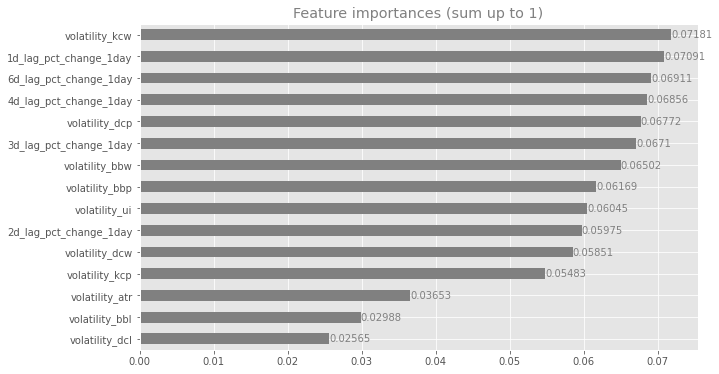


     . Optuna hyperparameters optimization finished
     .. Best trial number:75    |     rmse:          0.06120100918241552
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  217   |     rmse:           0.3035597554892872

Time elapsed for fit execution: 2 min 47.995 sec


In [294]:
#Hyper Parameter Tuning LGBM
from verstack import LGBMTuner
tuned_lgbm = LGBMTuner(metric = 'rmse') 
tuned_lgbm.fit(train_df_final_v1, train_target)

In [297]:
# prediction using tuned lgbm model

from sklearn.metrics import mean_squared_error
from math import sqrt


test_pred = tuned_lgbm.predict(test_df_final_v1)
rms = sqrt(mean_squared_error(test_target, test_pred))
print("Root mean squared error on test:",rms)

Root mean squared error on test: 0.04850202285455725


Our tuned LGBM using Vestack is performing worse than our untuned LGBM model

### XG Boost Regression

In [383]:
import xgboost as xgb

#creating train and test matrix for xgb 
dmatrix_train = xgb.DMatrix(data=train_df_final_v1,label=train_target)
dmatrix_test = xgb.DMatrix(data=test_df_final_v1,label=test_target)

In [384]:
#setting the params for xgb
params = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'n_estimators':25}

evallist = [(dmatrix_test, 'eval'), (dmatrix_train, 'train')]

num_round = 10
#training xg model
xg_reg = xgb.train(params,dmatrix_train,num_round)

[16:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [385]:
# prediction
test_pred_xg = xg_reg.predict(dmatrix_test)
#calculating rmse
rms = sqrt(mean_squared_error(test_target, test_pred_xg))
print("Root mean squared error on test for XGBOOST:",rms)

Root mean squared error on test for XGBOOST: 0.052040710210716636


### Random Forest

In [386]:
from sklearn.ensemble import RandomForestRegressor

#setting params for rf
N_ESTIMATORS = 25
RANDOM_STATE = 452543634
#loading the rf model
RF_base_model = RandomForestRegressor(n_estimators=N_ESTIMATORS,random_state=RANDOM_STATE)
#fitting the model
RF_base_model.fit(train_df_final_v1,train_target)

RandomForestRegressor(n_estimators=25, random_state=452543634)

In [388]:
# prediction
test_pred_rf = RF_base_model.predict(test_df_final_v1)
#calculating rmse
rms = sqrt(mean_squared_error(test_target, test_pred_rf))
print("Root mean squared error on test for Random Forest:",rms)

Root mean squared error on test for Random Forest: 0.05097493461057416


### Elastic Net Regression

In [387]:
#Hyper Parameter Tuning the model
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
model.fit(train_df_final_v1,train_target)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

alpha: 0.100000
l1_ratio_: 0.000000


In [308]:
#Using the tuned Parameters for our model
Elastic_Net_model= ElasticNet(alpha= model.alpha_, l1_ratio= model.l1_ratio_)
# fit model
Elastic_Net_model.fit(train_df_final_v1,train_target)

ElasticNet(alpha=0.1, l1_ratio=0.0)

In [390]:
# prediction
test_pred_en = Elastic_Net_model.predict(test_df_final_v1)
#calculte rmse
rms = sqrt(mean_squared_error(test_target, test_pred_en))
print("Root mean squared error on test for Elastic Net Regression:",rms)

Root mean squared error on test for Elastic Net Regression: 0.048523745128252235


For creating the requirements file

In [321]:
from pip._internal.utils.misc import get_installed_distributions
import sys
#import numpy as np # imported to test whether numpy shows up, which it does!

def get_imported_packages():
    p = get_installed_distributions()
    p = {package.key:package.version for package in p}

    imported_modules = set(sys.modules.keys())
    
    imported_modules.remove('pip')

    modules = [(m, p[m]) for m in imported_modules if p.get(m, False)]

    return modules


def generate_requirements(filepath:str, modules):
    with open(filepath, 'w') as f:
        for module, version in modules:
            f.write(f"{module}=={version}")


generate_requirements('requirements.txt', get_imported_packages())